### Selection of year and corresponding Grand Prix

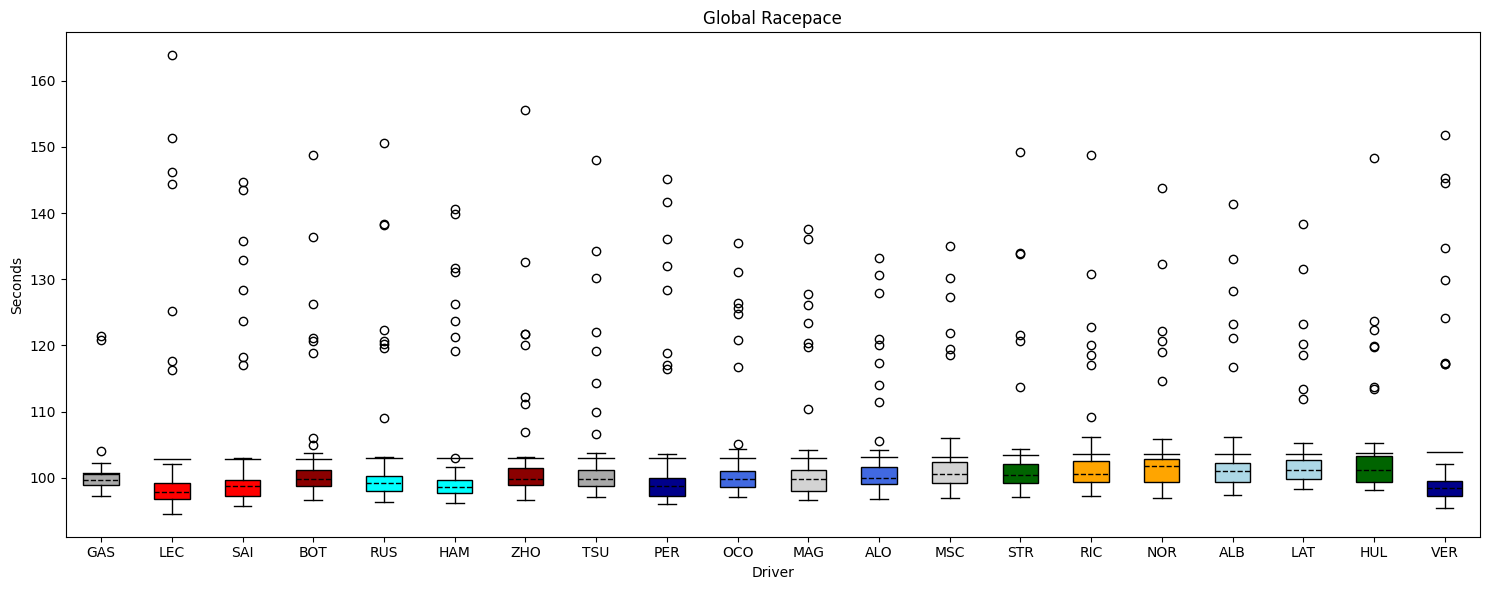

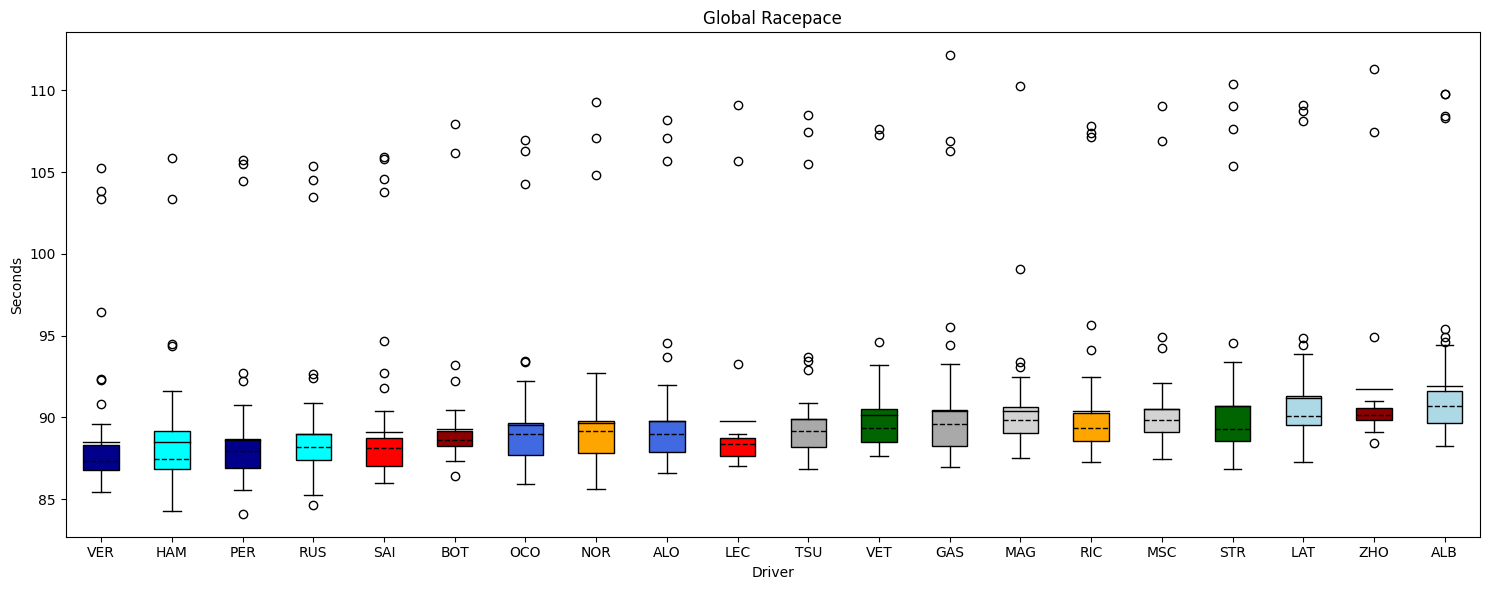

In [2]:
import pandas as pd
import tkinter as tk
import numpy as np
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Read the CSV files
races_df = pd.read_csv('data/races.csv') #raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
lap_times_df = pd.read_csv('data/lap_times.csv') #raceId,driverId,lap,position,time,milliseconds
drivers_df = pd.read_csv('data/drivers.csv') #driverId,driverRef,number,code,forename,surname,dob,nationality,url
driver_codes = drivers_df.set_index('driverId')['code'].to_dict()
results_df = pd.read_csv('data/results.csv') #resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
constructors_df = pd.read_csv('data/constructors.csv') #constructorId,constructorRef,name,nationality,url

# Define specific colors for constructors
constructor_colors = {
    'Red Bull': 'darkblue',
    'Mercedes': 'cyan',
    'Ferrari': 'red',
    'Alfa Romeo': 'darkred',
    'AlphaTauri': 'darkgrey',
    'Williams': 'lightblue',
    'McLaren': 'orange',
    'Aston Martin': 'darkgreen',
    'Alpine F1 Team': 'royalblue',
    'Haas F1 Team': 'lightgrey',
    'Renault': 'yellow',
    'Toro Rosso': 'darkgrey',
    'Force India': 'pink'
}

# Function to update the names based on the selected year
def update_names(event):
    selected_year = year_combobox.get()
    if selected_year.isdigit():
        names = races_df[races_df['year'] == int(selected_year)]['name']
        name_combobox['values'] = names.tolist()

# Function to get the raceId and plot the corresponding graph
def get_race_id_and_plot():
    selected_year = year_combobox.get()
    selected_name = name_combobox.get()
    selected_option = option_combobox.get()
    if selected_year.isdigit():
        race_id = races_df[(races_df['year'] == int(selected_year)) & (races_df['name'] == selected_name)]['raceId'].values[0]
        if selected_option == 'Global Racepace':
            plot_boxplot(race_id)
        elif selected_option == 'Lap-by-Lap Racepace':
            plot_lineplot(race_id)
        if selected_option == 'Position per Lap':
            plot_position_per_lap(race_id)
        if selected_option == 'Driver Standings':
            plot_drivers_standings(race_id)
        elif selected_option == 'Constructor Standings':
            plot_constructor_standings(race_id)

current_canvas = None

def plot_boxplot(race_id):
    global current_canvas
    race_data = lap_times_df[lap_times_df['raceId'] == race_id].query('lap > 2')
    
    # Compute the mean and standard deviation of milliseconds for the race
    mean_milliseconds = race_data['milliseconds'].mean()
    std_milliseconds = race_data['milliseconds'].std()

    # Exclude laps that are likely to be pit stops, based on a threshold of mean + 2 standard deviations
    threshold = mean_milliseconds + 2 * std_milliseconds
    #race_data = race_data[race_data['milliseconds'] < threshold]

    # Create a mapping between driverId and constructorId for the specific raceId
    driver_constructor_mapping = results_df[results_df['raceId'] == race_id].set_index('driverId')['constructorId'].to_dict()
    # Create a mapping between constructorId and constructor name
    constructor_names = constructors_df.set_index('constructorId')['name'].to_dict()

    # Group by driverId and sort by the mean of the 'milliseconds' column
    sorted_drivers = race_data.groupby('driverId')['milliseconds'].mean().sort_values()
    sorted_driver_ids = sorted_drivers.index.tolist()

    # Get the data for each driver in the sorted order and divide by 1000 to get seconds
    data_to_plot = [race_data[race_data['driverId'] == driver_id]['milliseconds'] / 1000 for driver_id in sorted_driver_ids]

    # Get the colors for each driver based on the constructor's team colors
    colors_to_plot = []
    for driver_id in sorted_driver_ids:
        constructor_id = driver_constructor_mapping.get(driver_id)
        constructor_name = constructor_names.get(constructor_id, 'Unknown') # set team 'Unknown' as default
        color = constructor_colors.get(constructor_name, 'black') # set color 'black' as default
        colors_to_plot.append(color)
        
    # Get the driver codes for each driver in the sorted order
    labels_to_plot = [driver_codes.get(driver_id, f'Driver {driver_id}') for driver_id in sorted_driver_ids]

    fig, ax = plt.subplots(figsize=(15,6))
    bp = ax.boxplot(data_to_plot, patch_artist=True, showmeans=True, meanline=True)
    
    # Set the colors of the boxplots and style of median and mean lines
    for patch, color, meanline, medianline in zip(bp['boxes'], colors_to_plot, bp['means'], bp['medians']):
        patch.set_facecolor(color)
        meanline.set_linestyle('-')  # Solid line for mean
        meanline.set_color('black')
        medianline.set_linestyle('--')  # Dashed line for median
        medianline.set_color('black')
        
    ax.set_title('Global Racepace')
    ax.set_xlabel('Driver')
    ax.set_ylabel('Seconds')
    # Set the x-axis labels to the driver codes
    ax.set_xticklabels(labels_to_plot, ha='center')

    # Set the colors of the boxplots
    for patch, color in zip(bp['boxes'], colors_to_plot):
        patch.set_facecolor(color)

    # Remove the current canvas if it exists
    if current_canvas is not None:
        current_canvas.get_tk_widget().destroy()

    # Create a new canvas
    canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea
    current_canvas = canvas
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack()
    plt.tight_layout(rect=[0, 0, 1, 1])  # Adjusts the plot to make room for the legend
    canvas.draw()
    
# Function to plot the lap-by-lap racepace for the given raceId
def plot_lineplot(race_id):
    global current_canvas
    race_data = lap_times_df[lap_times_df['raceId'] == race_id].query('lap > 2')
    
    # Compute the mean and standard deviation of milliseconds for the race
    #mean_milliseconds = race_data['milliseconds'].mean()
    #std_milliseconds = race_data['milliseconds'].std()
    
    # Exclude laps that are likely to be pit stops, based on a threshold of mean + 2 standard deviations
    #threshold = mean_milliseconds + 1 * std_milliseconds
    #race_data = race_data[race_data['milliseconds'] < threshold]    

    # Create a mapping between driverId and constructorId for the specific raceId
    driver_constructor_mapping = results_df[results_df['raceId'] == race_id].set_index('driverId')['constructorId'].to_dict()

    # Create a mapping between constructorId and constructor name
    constructor_names = constructors_df.set_index('constructorId')['name'].to_dict()

    fig, ax = plt.subplots(figsize=(15,6))
    
    # Keep track of the drivers plotted for each constructor
    plotted_constructors = {}

    # Plot a line for each driver, using the constructor's specific color
    for driver_id in race_data['driverId'].unique():
        driver_data = race_data[race_data['driverId'] == driver_id]
        
        # Calculate the moving average for the milliseconds column
        window_size = 15  # You can adjust this value
        smoothed_milliseconds = (driver_data['milliseconds'] / 1000).rolling(window=window_size, center=True).median().dropna()
        valid_laps = driver_data['lap'].loc[smoothed_milliseconds.index]
        
        constructor_id = driver_constructor_mapping.get(driver_id)
        name_code = driver_codes.get(driver_id, f'Driver {driver_id}')
        constructor_name = constructor_names.get(constructor_id, 'Unknown')
        color = constructor_colors.get(constructor_name, 'black')

        # Set line style based on whether this is the first or second driver for the constructor
        linestyle = '-' if constructor_id not in plotted_constructors else '--'
        plotted_constructors[constructor_id] = True

        ax.plot(valid_laps, smoothed_milliseconds, label=f'{name_code}', color=color, linestyle=linestyle)

    # ... (rest of the code for labels, legend, etc.) ...
    ax.set_title('Lap-by-Lap Racepace')
    ax.set_xlabel('Lap')
    ax.set_ylabel('Seconds')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    # Remove the current canvas if it exists
    if current_canvas is not None:
        current_canvas.get_tk_widget().destroy()

    # Create a new canvas
    canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea
    current_canvas = canvas
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack()
    plt.tight_layout(rect=[0, 0, 1, 1])  # Adjusts the plot to make room for the legend
    canvas.draw()
    
def plot_position_per_lap(race_id):
    global current_canvas
    # Get race data
    race_data = lap_times_df[lap_times_df['raceId'] == race_id]

    # Create a mapping between driverId and constructorId for the specific raceId
    driver_constructor_mapping = results_df[results_df['raceId'] == race_id].set_index('driverId')['constructorId'].to_dict()

    # Create a mapping between constructorId and constructor name
    constructor_names = constructors_df.set_index('constructorId')['name'].to_dict()

    # Get the final positions of the drivers
    sorted_drivers = results_df[results_df['raceId'] == race_id].sort_values(by='positionOrder')['driverId']

    # Create a mapping between driverId and driver code
    driver_codes = drivers_df.set_index('driverId')['code'].to_dict()

    fig, ax = plt.subplots(figsize=(15,6))

    # Plot a line for each driver in the sorted order
    for driver_id in sorted_drivers:
        driver_data = race_data[race_data['driverId'] == driver_id]
        constructor_id = driver_constructor_mapping.get(driver_id)
        constructor_name = constructor_names.get(constructor_id, 'Unknown')
        color = constructor_colors.get(constructor_name, 'black')
        driver_code = driver_codes.get(driver_id, 'Unknown')
        
        ax.plot(driver_data['lap'], driver_data['position'], marker='o', color=color, linestyle='-')
        
        # Get the x and y coordinates for the last point
        x_last_point = driver_data['lap'].iloc[-1]
        y_last_point = driver_data['position'].iloc[-1]
        
        # Set an offset to move the text closer to the last point and slightly higher
        x_offset = 0.05  # Adjust this value to move the text horizontally
        y_offset = -0.3  # Adjust this value to move the text vertically

        # Add the driver code at the end of the line with the specified offsets
        ax.text(x_last_point + x_offset, y_last_point + y_offset, driver_code, color=color, verticalalignment='center')


    ax.set_title('Position per Lap')
    ax.set_xlabel('Lap')
    ax.set_ylabel('Position')
    ax.set_ylim(ax.get_ylim()[::-1]) # Reverse y-axis to make position 1 at the top

    # Add integers for the finishing positions on both sides
    finishing_positions = sorted(results_df[results_df['raceId'] == race_id]['positionOrder'].unique())
    ax.set_yticks(finishing_positions)
    ax.yaxis.set_tick_params(labelright=True)
    
    # Remove the current canvas if it exists
    if current_canvas is not None:
        current_canvas.get_tk_widget().destroy()

    # Create a new canvas
    canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea
    current_canvas = canvas
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack()
    canvas.draw()
    
def plot_drivers_standings(race_id):
    global current_canvas
    # Get the season based on race_id
    season = races_df[races_df['raceId'] == race_id]['year'].iloc[0]

    # Filter races up to the given race_id for the specific season
    standings_df = results_df[(results_df['raceId'] <= race_id) & (results_df['raceId'].isin(races_df[races_df['year'] == season]['raceId']))]

    # Group by driverId and sum the points
    driver_points = standings_df.groupby('driverId')['points'].sum().reset_index()

    # Merge with driver information
    driver_points = pd.merge(driver_points, drivers_df, on='driverId')

    # Sort by points
    driver_points = driver_points.sort_values('points', ascending=False)

    # Get the colors for the plot
    def get_team_color(driver_id):
        constructor_id = standings_df[standings_df['driverId'] == driver_id]['constructorId'].iloc[-1]
        constructor_name = constructors_df[constructors_df['constructorId'] == constructor_id]['name'].iloc[0]
        return constructor_colors.get(constructor_name, 'black')

    driver_points['color'] = driver_points['driverId'].apply(get_team_color)

    fig, ax = plt.subplots(figsize=(15,6))
    ax.barh(driver_points['code'], driver_points['points'], color=driver_points['color'])
    ax.invert_yaxis()
    ax.set_xlabel('Points')
    ax.set_ylabel('Driver')
    ax.set_title(f'Driver Standings {season}')

    if current_canvas is not None:
        current_canvas.get_tk_widget().destroy()

    canvas = FigureCanvasTkAgg(fig, master=root)
    current_canvas = canvas
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack()
    canvas.draw()

def plot_constructor_standings(race_id):
    global current_canvas
    # Get the season based on race_id
    season = races_df[races_df['raceId'] == race_id]['year'].iloc[0]

    # Filter races up to the given race_id for the specific season
    standings_df = results_df[(results_df['raceId'] <= race_id) & (results_df['raceId'].isin(races_df[races_df['year'] == season]['raceId']))]

    # Group by driverId and sum the points
    driver_points = standings_df.groupby('driverId')['points'].sum().reset_index()

    # Merge with the standings_df to get the right constructorId
    driver_points = pd.merge(driver_points, standings_df[['driverId', 'constructorId']].drop_duplicates(), on='driverId')

    # Group by constructorId and sum the points again
    constructor_points = driver_points.groupby('constructorId')['points'].sum().reset_index()

    # Retrieve constructor name and color
    constructor_points['name'] = constructor_points['constructorId'].apply(lambda x: constructors_df[constructors_df['constructorId'] == x]['name'].iloc[0])
    constructor_points['color'] = constructor_points['name'].apply(lambda x: constructor_colors.get(x, 'black'))

    # Sort by points
    constructor_points = constructor_points.sort_values('points', ascending=False)

    fig, ax = plt.subplots(figsize=(15,6))
    ax.barh(constructor_points['name'], constructor_points['points'], color=constructor_points['color'])
    ax.invert_yaxis()
    ax.set_xlabel('Points')
    ax.set_ylabel('Constructor')
    ax.set_title(f'Constructor Standings {season}')

    if current_canvas is not None:
        current_canvas.get_tk_widget().destroy()

    canvas = FigureCanvasTkAgg(fig, master=root)
    current_canvas = canvas
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack()
    canvas.draw()

# Create the main window
root = tk.Tk()
root.title("Select Year and Name")

# Create a combobox for selecting the year
year_combobox = ttk.Combobox(root, values=sorted(races_df['year'].unique()))
year_combobox.pack()

# Bind the update_names function to the selection event of the year_combobox
year_combobox.bind('<<ComboboxSelected>>', update_names)

# Create a combobox for displaying the names corresponding to the selected year
name_combobox = ttk.Combobox(root)
name_combobox.pack()

# Create a combobox for selecting the option
options = ['Global Racepace', 'Lap-by-Lap Racepace', 'Position per Lap', 'Driver Standings', 'Constructor Standings']
option_combobox = ttk.Combobox(root, values=options)
option_combobox.pack()

# Button to get the raceId and plot the graph based on the selected year, name, and option
get_race_id_button = tk.Button(root, text="Plot", command=get_race_id_and_plot)
get_race_id_button.pack()

# Label to display the raceId
race_id_label = tk.Label(root, text="")
race_id_label.pack()

# Run the Tkinter event loop
root.mainloop()